# quant sandbox: *Food Fight!*
This notebook lets me play around with quantitative analysis of Altru output. Currently set up to take two files, one with program data and another with attendee data, and customized for the Food Fight program series.

**HOW TO USE THIS JUPYTER NOTEBOOK:** highlight the cell by clicking on it. You should see a green or blue box surround it. Then hold the Shift key and press Enter. You should see the highlight box move on to the next cell, and it will print or plot whatever the code says to do.
Try it here. Click on the gray text box below to highlight the cell, then hold Shift and press Enter.

In [1]:
print("Hello world!")

Hello world!


If it says **Hello world!** to you below the gray cell, it worked!

## Import statements, classes, and methods. 
Run these (Shift, Enter) then keep going. They shouldn't spit anything out at you. If they do, tell Abbie.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import ipywidgets as widgets
import traitlets
from IPython.display import display
from tkinter import Tk, filedialog

In [3]:
class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"    

In [4]:
def convert_yesno_to_bool(yesno):
    """ This method converts 'yes' and 'no' in an Altru excel file to boolean values."""
    if yesno.casefold() == "yes".casefold():
        return True
    elif yesno.casefold() == "no".casefold():
        return False
    else:
        return np.nan

In [5]:
def clean_up_df(raw_df):
    """ 
    This method takes a dataframe with program information like Name, Location, Date, Time, Capacity, 
    and two rows for Attended, one with a number for 'Yes' and another with a number for 'No'
    """
    clean_df = pd.DataFrame(columns=('Name', 'Type', 'Location', 'Date', 'Time', 'Day', 
                                     'Capacity', 'Preregistered', 'Attended', 'Percentage'))
    clean_df['Name'] = raw_df['Name'].unique()
#     print(clean_df['Name'])
    for i in range(len(clean_df)):
        namemask = raw_df.where(raw_df['Name'] == clean_df['Name'][i])
        fvi = namemask.first_valid_index()
        clean_df['Location'][i] = namemask['Location'][fvi]
        clean_df['Date'][i] = pd.to_datetime(namemask['Date'][fvi])
        clean_df['Time'][i] = namemask['Time'][fvi]
        clean_df['Capacity'][i] = namemask['Capacity'][fvi]
        yes_fvi = namemask.where(namemask['Attended'] == "Yes").first_valid_index()
        if yes_fvi == None:
            clean_df['Attended'][i] = 0
        else:
            clean_df['Attended'][i] = namemask['Number'][yes_fvi]
        no_fvi = namemask.where(namemask['Attended'] == "No").first_valid_index()
        if no_fvi == None:
            clean_df['Preregistered'][i] = clean_df['Attended'][i]
        else:
            clean_df['Preregistered'][i] = clean_df['Attended'][i] + namemask['Number'][no_fvi]
                                                                                    
    clean_df['Percentage'] = clean_df['Attended'] / clean_df['Preregistered']
    clean_df.sort_values(by="Date", inplace=True)
    clean_df['Day'] = [j.strftime('%a') for j in clean_df['Date']]

    return clean_df

## Run the cell below, then click the button to select your data file to load. 

The code expects an .xlsx data file made in Altru with the 'Program Query: Food Fight!' ad-hoc query. This file makes columns for the program name, program location, program date and time, participant capacity as specified in Altru, number of spaces still available, then two rows for each program: one with the number of pre-registrants who attended, and one with the number of pre-registrants who did not.

In [6]:
# button1 = SelectFilesButton()
# button1  # This will display the button in the context of Jupyter Notebook

Run this next cell to assign that file name to a variable and read in the excel file, then make a Pandas Dataframe called `programs` with the cleaned data. It will print basic information about the `programs` dataframe.

In [7]:
# program_xlsx_file = button1.files[0]
program_xlsx_file = "./foodfight_program_query.xlsx"
raw_program_data = pd.read_excel(program_xlsx_file, engine='openpyxl')
programs = clean_up_df(raw_program_data)
print(programs.info())

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 11 to 3
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           30 non-null     object
 1   Type           0 non-null      object
 2   Location       30 non-null     object
 3   Date           30 non-null     object
 4   Time           30 non-null     object
 5   Day            30 non-null     object
 6   Capacity       30 non-null     object
 7   Preregistered  30 non-null     object
 8   Attended       30 non-null     object
 9   Percentage     30 non-null     object
dtypes: object(10)
memory usage: 2.6+ KB
None


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In order to do analysis about workshops, conversations, and performances, we need to allocate the 'Type' of program based on keywords in the title. Change these if you need to, and make them specific as needed to get this to work right.

In [8]:
## Keywords to search for to allocate workshops, conversations, performances, and other not listed
workshops = ['workshop', 'ethnobotany', 'food landscape', 'farmers market', 'flavor', "art on the farm"]
conversations = ['intersection', 'conversation', 'discussion', 'fast out']
performances = ['screening', 'poetry slam', 'dancers', 'performance']

for i in range(len(programs)):
    for keyword in workshops:
        if keyword.casefold() in programs['Name'].iloc[i].casefold():
            programs['Type'].iloc[i] = "Workshop"
    for keyword in conversations:
        if keyword.casefold() in programs['Name'].iloc[i].casefold():
            programs['Type'].iloc[i] = "Conversation"
    for keyword in performances:
        if keyword.casefold() in programs['Name'].iloc[i].casefold():
            programs['Type'].iloc[i] = "Performance"
    if "cancelled".casefold() in programs['Name'].iloc[i].casefold():
        programs['Type'].iloc[i] = "Other"
        programs['Percentage'].iloc[i] = np.nan
    elif "postponed".casefold() in programs['Name'].iloc[i].casefold():
        programs['Type'].iloc[i] = "Other"
        programs['Percentage'].iloc[i] = np.nan

#     w_idx = programs['Name'].str.casefold().str.contains("workshop".casefold())
#     programs['Type'][w_idx] = "Workshop"

type_cats = ['Workshop', 'Conversation', 'Performance', 'Other']
programs['Type'] = pd.Categorical(programs['Type'], categories=type_cats, ordered=True)
nan_idx = programs['Type'].isnull()
programs['Type'][nan_idx] = 'Other'
programs['Location'].replace("Beal Botanical Garden", "Beal", inplace=True)
if programs['Location'].str.contains('STEM').any():
    programs['Location'].replace("STEM Teaching and Learning Facility", "STEM", inplace=True)
if programs['Location'].str.contains('Valley').any():
    programs['Location'].replace("Valley Court Park", "Valley Ct", inplace=True)
if programs['Location'].str.contains('Organic Farm').any():
    programs['Location'].replace("MSU Student Organic Farm", "SOF", inplace=True)    
display(programs)

,Name,Type,Location,Date,Time,Day,Capacity,Preregistered,Attended,Percentage
11,Food Fight! Opening Reception,Other,MSU Museum,2024-01-11 00:00:00,5:00 PM,Thu,500.0,290.0,173.0,0.596552
4,CANCELLED-Food Futures Performance,Other,MSU Museum,2024-01-12 00:00:00,12:10 PM,Fri,60.0,15.0,0,NaN
18,POSTPONED-Composting Workshop,Other,MSU Recycling Center,2024-01-18 00:00:00,5:00 PM,Thu,48.0,48.0,0,NaN
8,Ethnobotany On the Sphere: Chile Peppers,Workshop,MSU Museum,2024-01-20 00:00:00,1:00 PM,Sat,65.0,59.0,36.0,0.610169
5,CANCELLED-Michigan's Food Landscape,Other,MSU Museum,2024-01-21 00:00:00,1:00 PM,Sun,2.0,2.0,0,NaN
14,Intersection: Food Deserts and Public Policy,Conversation,MSU Museum,2024-01-25 00:00:00,7:00 PM,Thu,120.0,65.0,25.0,0.384615
16,Mushrooms in a Bottle,Other,MSU Museum,2024-01-27 00:00:00,1:00 PM,Sat,90.0,86.0,53.0,0.616279
6,Discussion and Book Signing with Curtis Chin,Conversation,MSU Main Library,2024-02-01 00:00:00,7:00 PM,Thu,155.0,151.0,109.0,0.721854
10,Ethnobotany On the Sphere: Tea,Workshop,MSU Museum,2024-02-03 00:00:00,1:00 PM,Sat,61.0,61.0,21.0,0.344262
22,Vegan Cooking Workshop,Workshop,MSU Union,2024-02-04 00:00:00,1:00 PM,Sun,50.0,48.0,25.0,0.520833


If you have cancelled or postponed programs (or other reasons why the attendance percentage would be Not a Number), filter those out of what's going to be plotted.

In [9]:
nan_idx = programs['Percentage'].isnull()
programs = programs.loc[~nan_idx]

If the program series is ongoing, filter out the ones that haven't happened yet.

In [10]:
future_idx = programs['Date'] > pd.Timestamp.today()
programs = programs.loc[~future_idx]

If you want to filter out a specific program based on a keyword in the name.

In [11]:
cut_idx = ["Mushroom".casefold() not in item.casefold() for item in programs['Name']]
programs = programs.loc[cut_idx]

If you had drop-in programs and want to count the numbers but not skew the attendance percentages, set the percentage to NaN.

In [12]:
dropin_idx = ["Cookbooks".casefold() in item.casefold() for item in programs['Name']]
programs['Percentage'].loc[dropin_idx] = np.nan

In [13]:
display(programs['Name'])

11                        Food Fight! Opening Reception
8              Ethnobotany On the Sphere: Chile Peppers
14         Intersection: Food Deserts and Public Policy
6          Discussion and Book Signing with Curtis Chin
10                       Ethnobotany On the Sphere: Tea
22                               Vegan Cooking Workshop
17                    Peshawbestown Dancers and Singers
9                  Ethnobotany On the Sphere: Chocolate
1                 "The Body Fights Back" Film Screening
23        Wellness Wednesday Workshop #1: Seed Exchange
2              "The Trilogy of Tomorrow" Film Screening
24     Wellness Wednesday Workshop #2: Sweetgrass Twine
25    Wellness Wednesday Workshop #3: Cold-Hardy Pla...
26      Wellness Wednesday Workshop #4: Chickweed Salad
20    The Food That Grows on Water: A Conversation o...
27             Wellness Wednesday Workshop #5: Weed Tea
19                          Taking the Fast Out of Food
28    Wellness Wednesday Workshop #6: Spring Eph

## Let's get some basic numbers!

How many people have attended *Food Fight!* programs so far?

In [14]:
programs['Attended'].sum()

1004.0

How many people have pre-registered for a *Food Fight!* program so far?

In [15]:
programs['Preregistered'].sum()

1983.0

Plot the attendance of programs as a function of time!

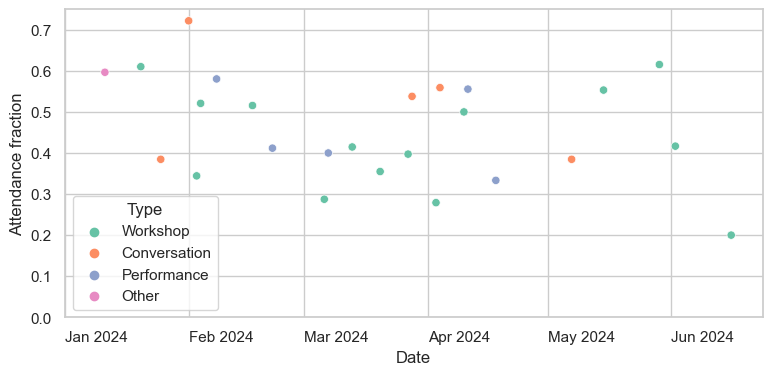

In [16]:
fig, ax = plt.subplots(figsize=(9,4))
sns.set_palette("Set2")
fig = sns.scatterplot(data=programs, x='Date', y='Percentage', hue='Type')
x_dates = pd.date_range(start='1/2024', end='6/2024', freq='MS', inclusive='both')
ax.set_xticks(x_dates, labels=x_dates.strftime('%b %Y'), horizontalalignment='left')
## TODO: mouseover to read name?!?
ax.set(ylim=(0, 0.75), ylabel="Attendance fraction")
fig.figure.savefig("program_attendance_timeline_scatter.png",bbox_inches='tight')
plt.show()

## Program type

In [17]:
print("\tMEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Type', observed=False)['Percentage'].mean())
print("\tERROR ON MEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Type', observed=False)['Percentage'].std())

	MEAN ATTENDANCE PERCENTAGE:


Type
Workshop        0.429235
Conversation    0.517621
Performance     0.456193
Other           0.596552
Name: Percentage, dtype: object

	ERROR ON MEAN ATTENDANCE PERCENTAGE:


Type
Workshop        0.128000
Conversation    0.140736
Performance     0.106659
Other                NaN
Name: Percentage, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


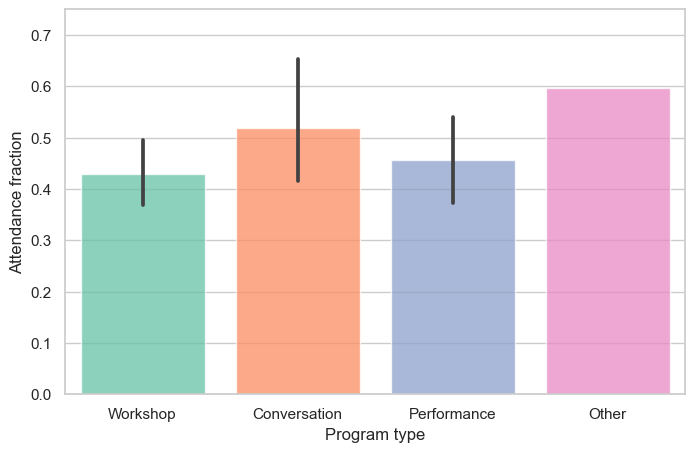

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
sns.set_palette("Set2")
fig = sns.barplot(data=programs.sort_values('Type'), x='Type', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="Program type", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("program_type_bar.png", bbox_inches='tight')
plt.show()

## Program location

Rank the locations by number of programs held there.

In [19]:
loc_cats = programs['Location'].value_counts(ascending=False, dropna=True).index
programs['Location'] = pd.Categorical(programs['Location'], categories=loc_cats, ordered=True)

How was attendance of programs based on their location?

In [20]:
print("\tMEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Location', observed=False)['Percentage'].mean())
print("\tERROR ON MEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Location', observed=False)['Percentage'].std())

	MEAN ATTENDANCE PERCENTAGE:


Location
MSU Museum          0.458854
Beal                0.430488
MSU Main Library    0.721854
MSU Union           0.520833
RCAH                0.580311
Valley Ct           0.416667
SOF                      0.2
Name: Percentage, dtype: object

	ERROR ON MEAN ATTENDANCE PERCENTAGE:


Location
MSU Museum          0.114632
Beal                0.102140
MSU Main Library         NaN
MSU Union                NaN
RCAH                     NaN
Valley Ct                NaN
SOF                      NaN
Name: Percentage, dtype: float64

Note: `NaN`, or `Not a Number`, is listed for the standard deviation on the last few because we only had one program at each of those locations.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


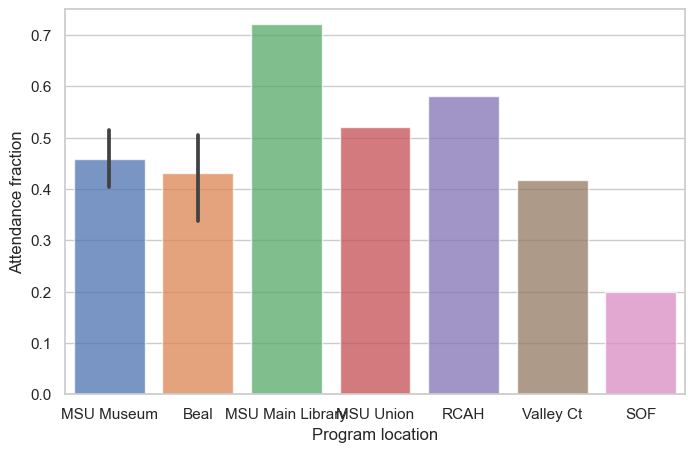

In [21]:
fig, ax = plt.subplots(figsize=(8,5))
sns.set_palette('deep')
fig = sns.barplot(data=programs, x='Location', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="Program location", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("program_location_bar.png", bbox_inches='tight')
plt.show()

It's worth noting that the Library and RCAH programs had very strong partnerships and co-sponsorships, which significantly boosted attendance, and it was raining for the outdoor program at Valley Court Park, which didn't help attendance.

## Time of day

In [22]:
print("\tMEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Time')['Percentage'].mean())
print("\tERROR ON MEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Time')['Percentage'].std())

	MEAN ATTENDANCE PERCENTAGE:


Time
11:30 AM    0.416667
12:00 PM    0.396371
1:00 PM     0.467712
5:00 PM     0.464943
7:00 PM      0.51889
Name: Percentage, dtype: object

	ERROR ON MEAN ATTENDANCE PERCENTAGE:


Time
11:30 AM         NaN
12:00 PM    0.094998
1:00 PM     0.163785
5:00 PM     0.186124
7:00 PM     0.114600
Name: Percentage, dtype: float64

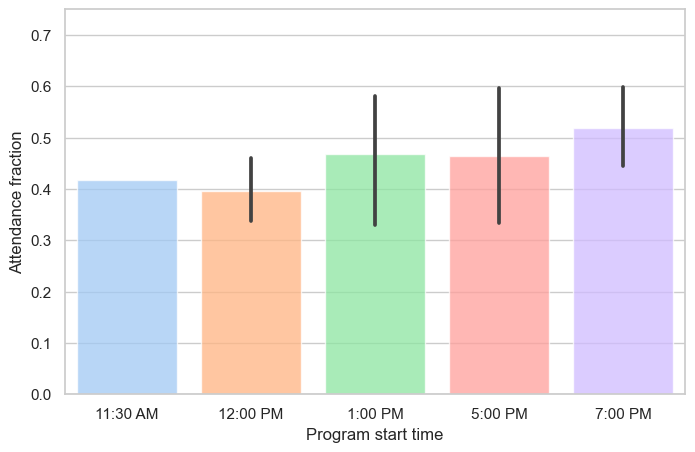

In [23]:
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=programs.sort_values('Time'), x='Time', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="Program start time", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("program_time_bar.png", bbox_inches='tight')
plt.show()

The 12pm programs were on weekdays, so day of the week is also a factor.

## Day of week

Sort days of the week in calendar order, not alphabetical order.

In [24]:
day_cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
programs['Day'] = pd.Categorical(programs['Day'], categories=day_cats, ordered=True)

In [25]:
print("\tMEAN ATTENDANCE PERCENTAGE:")
display(programs.sort_values('Day').groupby('Day', observed=True)['Percentage'].mean())
print("\tERROR ON MEAN ATTENDANCE PERCENTAGE:")
display(programs.groupby('Day', observed=True)['Percentage'].std())

	MEAN ATTENDANCE PERCENTAGE:


Day
Tue    0.384615
Wed    0.425217
Thu      0.5081
Sat    0.490019
Sun    0.379167
Name: Percentage, dtype: object

	ERROR ON MEAN ATTENDANCE PERCENTAGE:


Day
Tue         NaN
Wed    0.122092
Thu    0.120753
Sat    0.134790
Sun    0.163671
Name: Percentage, dtype: float64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


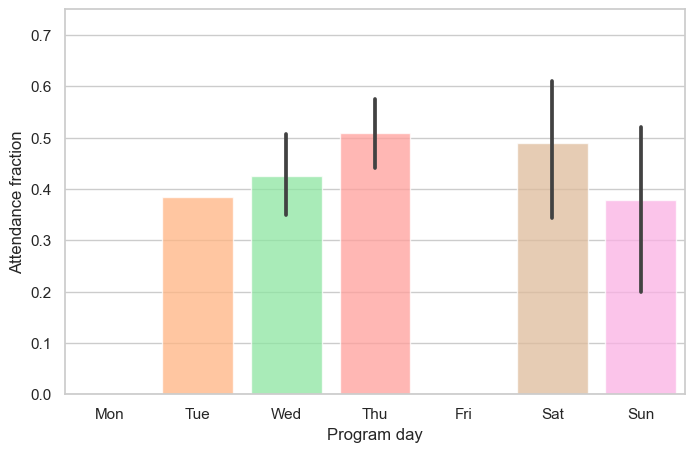

In [26]:
sns.set_palette("pastel")
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=programs.sort_values('Day'), x='Day', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="Program day", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("program_day_bar.png", bbox_inches='tight')
plt.show()

Keep in mind that the Tuesday and Wednesday programs were lunchtime programs, and Thursday programs were in the evening, so time of day is at play here as well.

# Program attendees

Now we can get nitty-gritty. Let's load in the data file with all the registrants for each program.

**VERY IMPORTANT NOTE:** You need to open the excel file and double-check that the non-MSU affiliation says "Not MSU" instaed of "None". Otherwise, having no MSU affiliation gets merged with the people for whom we don't have that information. If needed, do find-replace to switch "None" to "Not MSU".

In [27]:
# button2 = SelectFilesButton()
# button2  # This will display the button in the context of Jupyter Notebook

In [28]:
# reg_xlsx_file = button2.files[0]
reg_xlsx_file = "./foodfight_registrant_query.xlsx"

In [29]:
registrants = pd.read_excel(reg_xlsx_file, engine='openpyxl', converters={'Attended': convert_yesno_to_bool})
display(registrants.info())
registrants['Program location'].replace("Beal Botanical Garden", "Beal", inplace=True)
registrants['Program location'].replace("Valley Court Park", "Valley Ct", inplace=True)
registrants['Program location'].replace("MSU Student Organic Farm", "SOF", inplace=True)
registrants['MSU affiliation'].replace("Faculty or Staff", "Faculty/Staff", inplace=True)  # Renaming this for consistency with Parent/Family
registrants['MSU affiliation'].fillna("N/A", inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2134 entries, 0 to 2133
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Visitor name      2134 non-null   object
 1   Attended          2134 non-null   bool  
 2   Host name         1270 non-null   object
 3   MSU affiliation   1596 non-null   object
 4   Program name      2134 non-null   object
 5   Program location  2134 non-null   object
 6   Number of guests  2134 non-null   int64 
 7   ZIP code          1735 non-null   object
 8   QUERYRECID        2134 non-null   object
dtypes: bool(1), int64(1), object(7)
memory usage: 135.6+ KB


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


None

We can assign a preferred order to display the MSU affiliations.

In [30]:
affil_cats = ['Student', 'Faculty/Staff', 'Alum', 'Parent/Family', 'Not MSU', 'N/A']
registrants['MSU affiliation'] = pd.Categorical(registrants['MSU affiliation'], categories=affil_cats, ordered=True)

Only keep the records of who attended a program that we kept in the `programs` dataframe, done by program name, since we did some filtering previously.

In [31]:
registrants = registrants[registrants['Program name'].isin(programs['Name'].unique().tolist())]
print(registrants['Program location'].unique())

['MSU Museum' 'Beal' 'MSU Main Library' 'RCAH' 'SOF' 'MSU Union'
 'Valley Ct']


Check if we get the same numbers as before.

In [32]:
print(len(registrants))
print(sum(registrants['Attended']))

1983
1004


Remove myself, since I sign up for every program to test the links and emails.

In [33]:
me_idx = ["Abbie Stevens".casefold() in item.casefold() for item in registrants['Visitor name']]
registrants['MSU affiliation'].loc[me_idx] = np.nan

Remove CoLab Studio, since that's our generic host for walk-ins. (I tried just removing its affiliation, but that threw errors down below with the `hosts` dataframe).

In [34]:
colab_idx = ["CoLab Studio".casefold() in item.casefold() for item in registrants['Visitor name']]
registrants['MSU affiliation'].loc[colab_idx] = np.nan

2-dimensional histograms are kinda weird but fun. We can look at total pre-registration as a function of MSU affiliation **and** program location!

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/2b/bxdw1yzn5_vb2kd7bdhn0z3c0000gr/T/ipykernel_90521/1026409643.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=345)


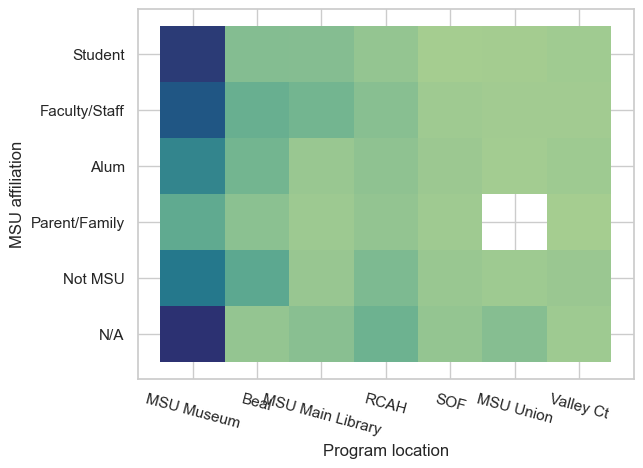

In [35]:
fig = sns.histplot(registrants, x='Program location', y='MSU affiliation', cmap='crest')
fig.set_xticklabels(fig.get_xticklabels(), rotation=345)
plt.show()

We can see that programs at Beal had a relatively higher number of `Not MSU` affiliations than programs at other locations. The program at RCAH was early in the semester, so lots of pre-registration happened before we realized we weren't collecting MSU affiliation data, hence the high number of `N/A` registrants.

In [36]:
registrants['Program type'] = pd.Categorical(np.empty(len(registrants)), categories=type_cats, ordered=True)
for i in range(len(registrants)):
    for keyword in workshops:
        if keyword.casefold() in registrants['Program name'].iloc[i].casefold():
            registrants['Program type'].iloc[i] = "Workshop"
    for keyword in conversations:
        if keyword.casefold() in registrants['Program name'].iloc[i].casefold():
            registrants['Program type'].iloc[i] = "Conversation"
    for keyword in performances:
        if keyword.casefold() in registrants['Program name'].iloc[i].casefold():
            registrants['Program type'].iloc[i] = "Performance"

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/2b/bxdw1yzn5_vb2kd7bdhn0z3c0000gr/T/ipykernel_90521/1785191084.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_yticklabels(fig.get_yticklabels(), rotation=45)


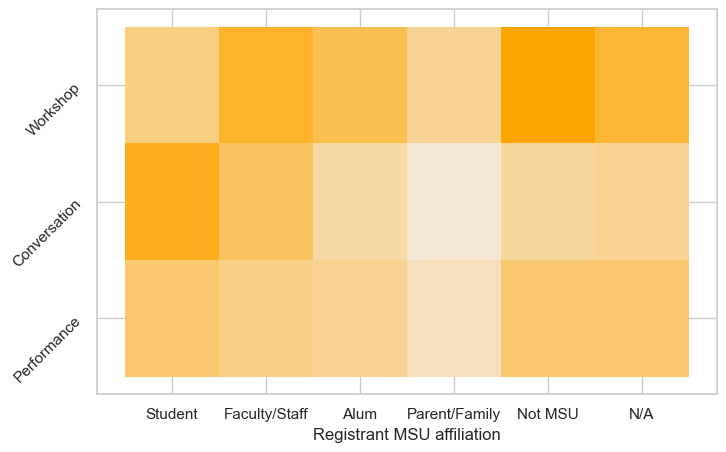

In [37]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.histplot(registrants, x='MSU affiliation', y='Program type', cmap='light:orange')
ax.set(xlabel="Registrant MSU affiliation", ylabel="")
fig.set_yticklabels(fig.get_yticklabels(), rotation=45)
fig.figure.savefig("2D_reg_affil_type.png", bbox_inches='tight')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/2b/bxdw1yzn5_vb2kd7bdhn0z3c0000gr/T/ipykernel_90521/1672719515.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_yticklabels(fig.get_yticklabels(), rotation=45)


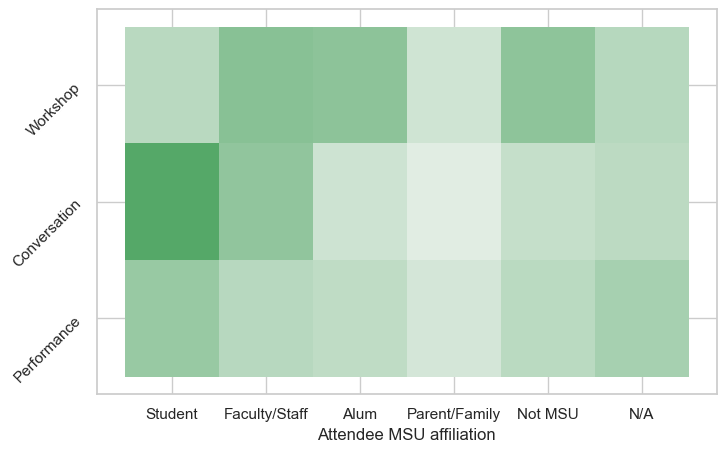

In [38]:
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.histplot(registrants.iloc[np.where(registrants['Attended'])], x='MSU affiliation', y='Program type', cmap='light:g')
ax.set(xlabel="Attendee MSU affiliation", ylabel="")
fig.set_yticklabels(fig.get_yticklabels(), rotation=45)
fig.figure.savefig("2D_attend_affil_type.png", bbox_inches='tight')
plt.show()

## MSU affiliation

Let's clean the registrant data and make a new dataframe where each individal is listed once, and we sum the number of pre-registrations and attendances they had.

In [39]:
reg_by_name = pd.DataFrame(columns=('Visitor name', 'Attended', 'Preregistered', 'Percentage', 'Host name', 'MSU affiliation'))
reg_by_name['Visitor name'] = registrants['Visitor name'].unique()
nas_with_other = 0
for i in range(len(reg_by_name['Visitor name'])):
    appearances = registrants['Visitor name'].values == reg_by_name['Visitor name'][i]
    reg_by_name['Preregistered'][i] = sum(appearances) # sum of times it appears in the whole registrants list.
    reg_by_name['Attended'][i] = sum(registrants['Attended'][appearances])#sum of attended where name == visitors name
    reg_by_name['Host name'][i] = registrants['Host name'][appearances].tolist()
    affil = registrants['MSU affiliation'][appearances].unique()
    if len(affil) > 1 and "N/A" in affil:
        reg_by_name['MSU affiliation'][i] = np.delete(affil, np.where(affil == 'N/A'))[0]
        nas_with_other += 1
    else:
        reg_by_name['MSU affiliation'][i] = affil[0]
reg_by_name['Percentage'] = reg_by_name['Attended'] / reg_by_name['Preregistered']
reg_by_name['MSU affiliation'] = pd.Categorical(reg_by_name['MSU affiliation'], categories=affil_cats, ordered=True)

In [40]:
print("Unique registrants: %d" % len(reg_by_name))
print("Unique attendees: %d" % len(np.where(reg_by_name['Attended'] > 0)[0]))

Unique registrants: 1520
Unique attendees: 821


In [41]:
print("\tSUM OF PRE-REGISTRATIONS:")
display(reg_by_name.groupby('MSU affiliation', observed=False)['Preregistered'].sum())
print("\tSUM OF ATTENDANCES:")
display(reg_by_name.groupby('MSU affiliation', observed=False)['Attended'].sum())
print("\tMEAN ATTENDANCE PERCENTAGE:")
display(reg_by_name.groupby('MSU affiliation', observed=False)['Percentage'].mean())

	SUM OF PRE-REGISTRATIONS:


MSU affiliation
Student          368
Faculty/Staff    388
Alum             254
Parent/Family    135
Not MSU          338
N/A              450
Name: Preregistered, dtype: object

	SUM OF ATTENDANCES:


MSU affiliation
Student          230
Faculty/Staff    213
Alum             137
Parent/Family     54
Not MSU          132
N/A              206
Name: Attended, dtype: object

	MEAN ATTENDANCE PERCENTAGE:


MSU affiliation
Student          0.633927
Faculty/Staff    0.585634
Alum             0.500622
Parent/Family    0.432477
Not MSU          0.383931
N/A              0.461248
Name: Percentage, dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


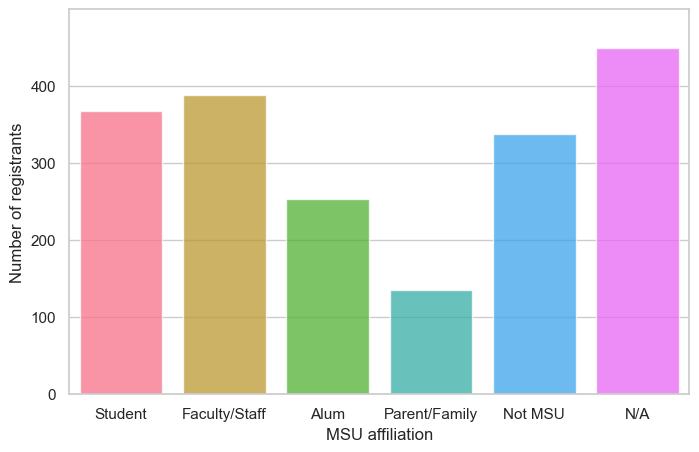

In [42]:
fig, ax = plt.subplots(figsize=(8,5))
sns.set_palette("husl")
fig = sns.barplot(data=reg_by_name, x='MSU affiliation', y='Preregistered', estimator=sum, saturation=1, alpha=0.75, errwidth=0)
ax.set(xlabel="MSU affiliation", ylabel="Number of registrants")
fig.figure.savefig("pre-reg_affil_bar.png", bbox_inches='tight')
plt.show()

In [43]:
# display(reg_by_name.sort_values(['Attended'], ascending=False).groupby('MSU affiliation', observed=True).head(3))

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


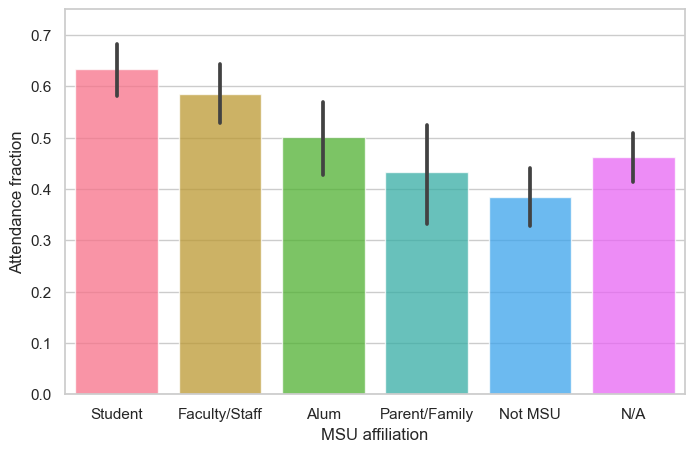

In [44]:
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=reg_by_name, x='MSU affiliation', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="MSU affiliation", ylabel="Attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("attend_affil_bar.png", bbox_inches='tight')
plt.show()

## Hosts
Categorize and sort the attendance by people who 'hosted' (pre-registered others as their guest), and assign it to a new dataframe `hosts`.

In [45]:
hosts = pd.DataFrame(columns=('Name', 'Attended', 'Preregistered', 'Percentage', 'MSU affiliation'))
hosts['Name'] = registrants['Host name'][registrants['Host name'].notnull()].unique()
for i in range(len(hosts)):
    h = registrants['Visitor name'] == hosts['Name'][i]
    t1 = registrants['MSU affiliation'][h & registrants['MSU affiliation'][h].notnull()].unique()
    if len(t1) > 1 and "N/A" in t1:
        hosts['MSU affiliation'][i] = np.delete(t1, np.where(t1 == 'N/A'))[0]
    elif len(t1) == 1:
        hosts['MSU affiliation'][i] = t1[0]
    else:
        hosts['MSU affiliation'][i] = np.nan
    t2 = registrants['Attended'][h]
    hosts['Attended'][i] = sum(registrants['Attended'][h])
    hosts['Preregistered'][i] = sum(h)
hosts['Percentage'] = hosts['Attended'] / hosts['Preregistered']
print("Number of unique people who pre-registered guests: %d" % len(hosts))

Number of unique people who pre-registered guests: 361


In [46]:
print("\tSUM OF PRE-REGISTRATIONS:")
display(hosts.groupby('MSU affiliation', observed=False)['Preregistered'].sum())

	SUM OF PRE-REGISTRATIONS:


MSU affiliation
Alum             112
Faculty/Staff    117
N/A               55
Not MSU          117
Parent/Family     30
Student           65
Name: Preregistered, dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


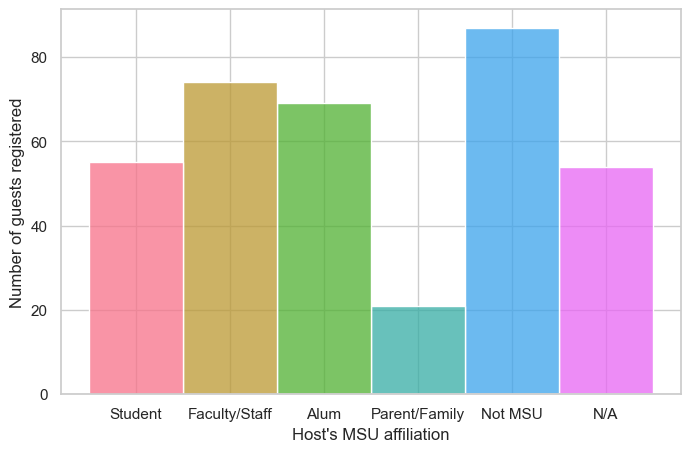

In [47]:
sns.set_palette("husl")
# sns.set_style("ticks")
hosts['MSU affiliation'] = pd.Categorical(hosts['MSU affiliation'], categories=affil_cats, ordered=True)
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.histplot(data=hosts.sort_values('MSU affiliation'), x='MSU affiliation', hue='MSU affiliation', legend=False, alpha=0.75)
ax.set(xlabel="Host's MSU affiliation", ylabel="Number of guests registered")
fig.figure.savefig("pre-reg_guests_affil_bar.png", bbox_inches='tight')
plt.show()

In [48]:
print("\tMEAN GUEST ATTENDANCE PERCENTAGE by MSU HOST AFFILIATION:")
display(hosts.groupby('MSU affiliation', observed=False)['Percentage'].mean())
print("\tSUM OF ATTENDANCES:")
display(hosts.groupby('MSU affiliation', observed=False)['Attended'].sum())

	MEAN GUEST ATTENDANCE PERCENTAGE by MSU HOST AFFILIATION:


MSU affiliation
Student          0.523636
Faculty/Staff    0.530405
Alum             0.483981
Parent/Family    0.188095
Not MSU          0.333943
N/A              0.481481
Name: Percentage, dtype: object

	SUM OF ATTENDANCES:


MSU affiliation
Student          36
Faculty/Staff    60
Alum             60
Parent/Family     6
Not MSU          40
N/A              26
Name: Attended, dtype: object

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


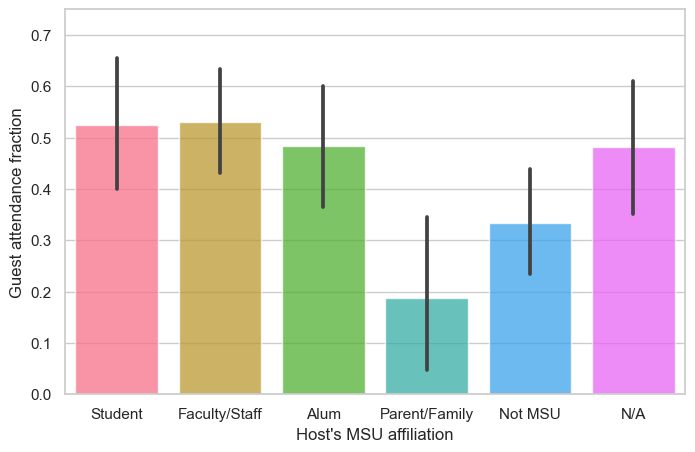

In [49]:
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(8,5))
fig = sns.barplot(data=hosts.sort_values('MSU affiliation'), x='MSU affiliation', y='Percentage', saturation=1, alpha=0.75)
ax.set(xlabel="Host's MSU affiliation", ylabel="Guest attendance fraction", ylim=(0, 0.75))
fig.figure.savefig("attend_guest_affil_bar.png", bbox_inches='tight')
plt.show()